## Session 6


Convolutional Autoencoder

In [1]:
import torch
import torchvision.datasets as dsets
import torch.nn as nn
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
from model import Encoder, Decoder, LogisticRegression
from evaluator import AutoEncoderEvaluator, ModelEvaluator

## Use latent features to train and test a simple MLP

In [2]:
def load_model(model_name, key='state_dict_encoder'):
    model_dir = '../Session6/model/' + model_name
    checkpoint = torch.load(model_dir)
    checkpoint = checkpoint[key]
    return checkpoint

In [3]:
batch_size = 100
lr = 0.001
# Model
l2 = 0.0
optim = 'adam'
model_epoch = 19
use_gpu= True

model_name = 'AutoEncoder_lr_{}_opt_{}_epoch_{}'.format(lr, optim, model_epoch)

encoder = Encoder(batch_size=batch_size)
decoder = Decoder(batch_size=batch_size)

if use_gpu:
    encoder = encoder.cuda()
    decoder = decoder.cuda()
encoder.load_state_dict(load_model(model_name, key='state_dict_encoder'))
decoder.load_state_dict(load_model(model_name, key='state_dict_decoder'))

In [4]:
encoder.eval()

Encoder(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, mome

In [5]:
decoder.eval()

Decoder(
  (layer1): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): ReLU()
  )
)

In [6]:
from matplotlib import pyplot as plt

Files already downloaded and verified
Files already downloaded and verified
Actual Input


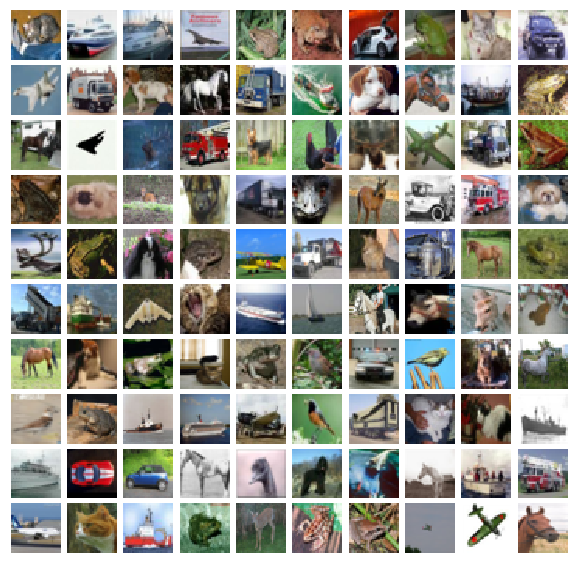

Reconstructed Output


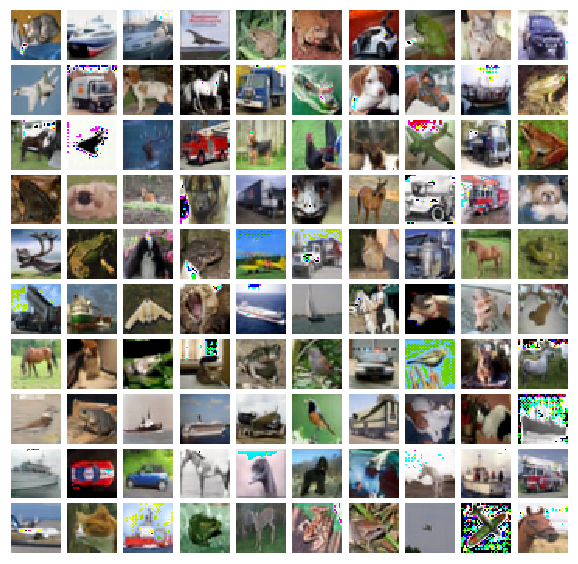

In [7]:
trainset = dsets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
testset = dsets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

def plot_img(tensor, num_cols=10):
  num_imgs = tensor.shape[0]
  num_rows = 1+ num_imgs // num_cols
  fig = plt.figure(figsize=(num_cols,num_rows))
  for i in range(num_imgs):
    ax1 = fig.add_subplot(num_rows,num_cols,i+1)
    ax1.imshow(tensor[i].transpose((1, 2, 0)))
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])

  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show() 

for images, labels in testloader:
    if use_gpu:
        images, labels = images.cuda(), labels.cuda()
    output = encoder.forward(images)
    output = decoder.forward(output)
    break

print('Actual Input')
plot_img(images.detach().cpu().numpy())
print('Reconstructed Output')
plot_img(output.detach().cpu().numpy())   

In [8]:
import numpy as np

In [9]:
n_in = 8192  # 128x8x8
n_hidden = 256
n_out = 10
epochs = 10
lr = 0.001
optim = 'adam'

model = LogisticRegression(n_in, n_hidden, n_out)
if use_gpu:
    model = model.cuda()
modeleval = ModelEvaluator(model, epochs, lr, use_gpu, optim)
acc_ = modeleval.evaluator(encoder, trainloader, testloader)

Train Epoch: 0 [0/50000 (0.00%)]	 Loss 2.311742
Train Epoch: 0 [10000/50000 (20.00%)]	 Loss 1.370268
Train Epoch: 0 [20000/50000 (40.00%)]	 Loss 1.490046
Train Epoch: 0 [30000/50000 (60.00%)]	 Loss 1.201164
Train Epoch: 0 [40000/50000 (80.00%)]	 Loss 1.191052
Accuracy of model on test set 59.00
Train Epoch: 1 [0/50000 (0.00%)]	 Loss 1.105154
Train Epoch: 1 [10000/50000 (20.00%)]	 Loss 1.095307
Train Epoch: 1 [20000/50000 (40.00%)]	 Loss 1.012890
Train Epoch: 1 [30000/50000 (60.00%)]	 Loss 0.962603
Train Epoch: 1 [40000/50000 (80.00%)]	 Loss 0.922187
Accuracy of model on test set 61.00
Train Epoch: 2 [0/50000 (0.00%)]	 Loss 0.842988
Train Epoch: 2 [10000/50000 (20.00%)]	 Loss 0.764551
Train Epoch: 2 [20000/50000 (40.00%)]	 Loss 0.761489
Train Epoch: 2 [30000/50000 (60.00%)]	 Loss 0.948884
Train Epoch: 2 [40000/50000 (80.00%)]	 Loss 0.996370
Accuracy of model on test set 63.00
Train Epoch: 3 [0/50000 (0.00%)]	 Loss 0.844460
Train Epoch: 3 [10000/50000 (20.00%)]	 Loss 0.713527
Train Epoch

AttributeError: 'Tensor' object has no attribute '2f'

In [10]:
print('Accuracy with latent features {}'.format(acc_))

Accuracy with latent features 65


## Denoising AutoEncoder

Add noise to encoder

In [15]:
batch_size = 100
lr = 0.001
optim = 'adam'
model_epoch = 19
model_name = 'AutoEncoder_lr_{}_opt_{}_epoch_{}_dae'.format(lr, optim, model_epoch)

encoder = Encoder(batch_size=batch_size)
decoder = Decoder(batch_size=batch_size)

if use_gpu:
    encoder = encoder.cuda()
    decoder = decoder.cuda()
    
encoder.load_state_dict(load_model(model_name, key='state_dict_encoder'))
decoder.load_state_dict(load_model(model_name, key='state_dict_decoder'))

In [16]:
encoder.eval()

Encoder(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, mome

In [17]:
decoder.eval()

Decoder(
  (layer1): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): ReLU()
  )
)

Actual Images


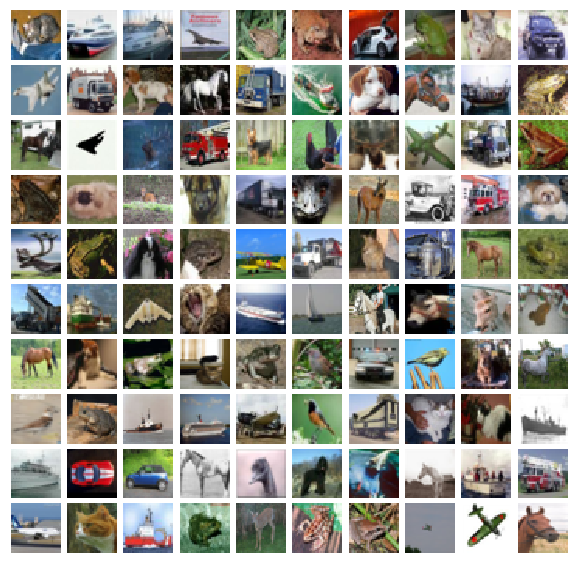

Input Images


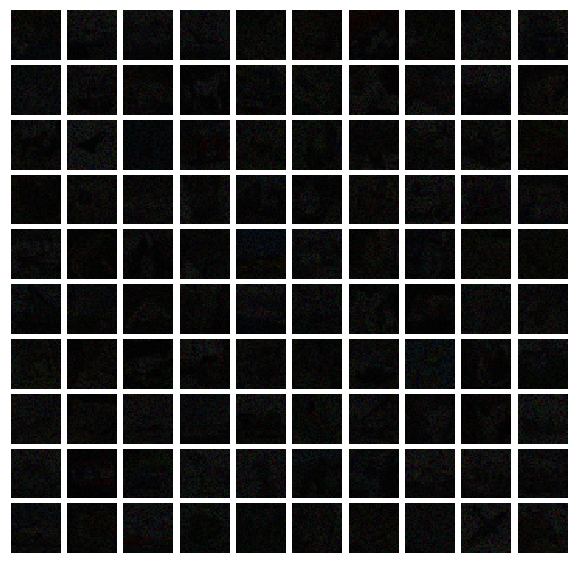

Reconstructed Output


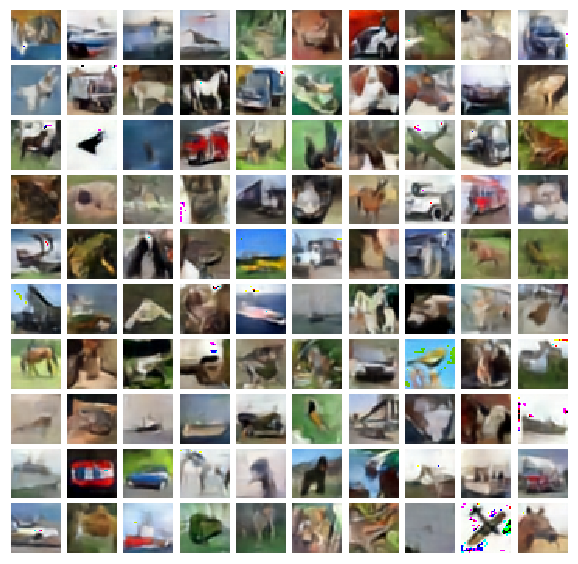

In [19]:
for images, labels in testloader:
    images_n = torch.mul(images+0.25, 0.1 * torch.rand(batch_size, 3, 32, 32))
    if use_gpu:
        images, labels, images_n = images.cuda(), labels.cuda(), images_n.cuda()
    output = encoder.forward(images_n)
    output = decoder.forward(output)
    break

print('Actual Images')
plot_img(images.detach().cpu().numpy())
print('Input Images')
plot_img(images_n.detach().cpu().numpy())
print('Reconstructed Output')
plot_img(output.detach().cpu().numpy())  

In [20]:
n_in = 8192  # 128x8x8
n_hidden = 256
n_out = 10
epochs = 10
lr = 0.001
optim = 'adam'

model = LogisticRegression(n_in, n_hidden, n_out)
if use_gpu:
    model = model.cuda()
modeleval = ModelEvaluator(model, epochs, lr, use_gpu, optim)
acc_ = modeleval.evaluator(encoder, trainloader, testloader)

Train Epoch: 0 [0/50000 (0.00%)]	 Loss 13.171129
Train Epoch: 0 [10000/50000 (20.00%)]	 Loss 2.227561
Train Epoch: 0 [20000/50000 (40.00%)]	 Loss 2.297348
Train Epoch: 0 [30000/50000 (60.00%)]	 Loss 2.080018
Train Epoch: 0 [40000/50000 (80.00%)]	 Loss 2.088441
Accuracy of model on test set 22.00
Train Epoch: 1 [0/50000 (0.00%)]	 Loss 1.973185
Train Epoch: 1 [10000/50000 (20.00%)]	 Loss 1.984339
Train Epoch: 1 [20000/50000 (40.00%)]	 Loss 1.862052
Train Epoch: 1 [30000/50000 (60.00%)]	 Loss 1.792354
Train Epoch: 1 [40000/50000 (80.00%)]	 Loss 1.775289
Accuracy of model on test set 29.00
Train Epoch: 2 [0/50000 (0.00%)]	 Loss 1.801432
Train Epoch: 2 [10000/50000 (20.00%)]	 Loss 1.833958
Train Epoch: 2 [20000/50000 (40.00%)]	 Loss 1.959642
Train Epoch: 2 [30000/50000 (60.00%)]	 Loss 1.721845
Train Epoch: 2 [40000/50000 (80.00%)]	 Loss 1.781723
Accuracy of model on test set 39.00
Train Epoch: 3 [0/50000 (0.00%)]	 Loss 1.531846
Train Epoch: 3 [10000/50000 (20.00%)]	 Loss 1.724162
Train Epoc

AttributeError: 'Tensor' object has no attribute '2f'

In [21]:
print('Accuracy with latent features {:.2f}'.format(acc_))

Accuracy with latent features 44.00


## Adam optimizer without torch.nn

In [42]:
from copy import copy
import torch

class Adam:
    def __init__(self, alpha, beta1, beta2, eps, use_gpu=False):
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.use_gpu = use_gpu

    def adam(self, gradient_t, theta_t_prev, convergence):
        t = 0
        m_t_prev, v_t_prev = torch.zeros_like(gradient_t), torch.zeros_like(gradient_t)
        if self.use_gpu:
            m_t_prev, v_t_prev, t = m_t_prev.cuda(), v_t_prev.cuda(), t.cuda() 

        while True:
            t += 1 
            m_t = beta1*m_t_prev + (1-beta1)*gradient_t
            v_t = beta2*v_t_prev + (1-beta2)*gradient_t**2
            m_hat = m_t/(1-beta1**t)
            v_hat = v_t/(1-beta2**t)
            theta_t = theta_t_prev - alpha*(m_hat/v_hat.sqrt().add_(eps))
            convergence.append(torch.norm(theta_t-theta_t_prev))
            if torch.norm(theta_t-theta_t_prev)<1e-4:
                break
            theta_t_prev = copy(theta_t)
        return theta_t_prev, convergence

    def run(self, gradient_t, theta_t_prev, convergence):
        theta_t, convergence = self.adam(gradient_t, theta_t_prev, convergence)
        return theta_t, convergence

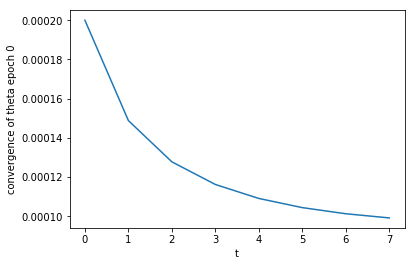

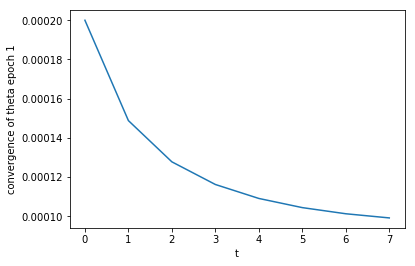

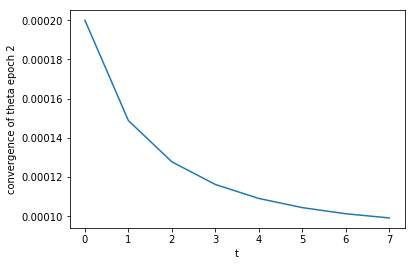

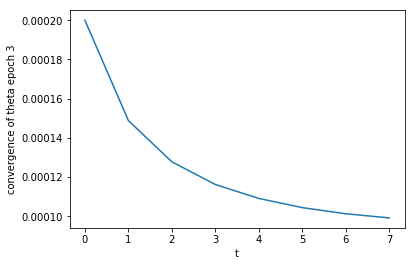

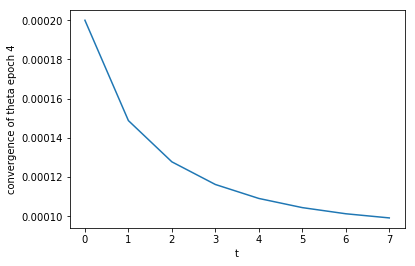

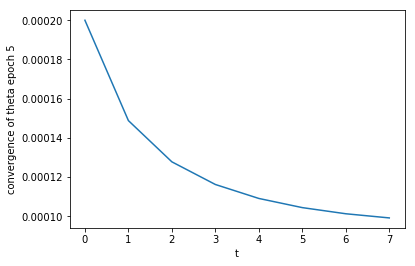

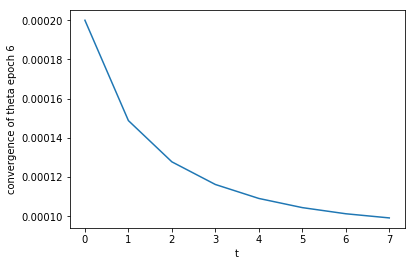

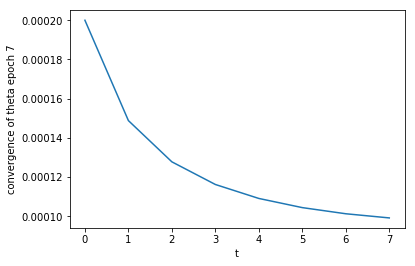

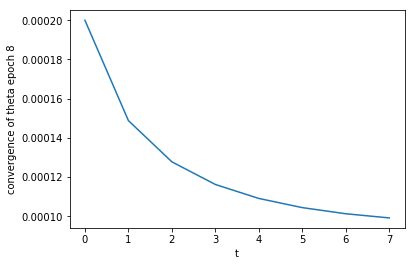

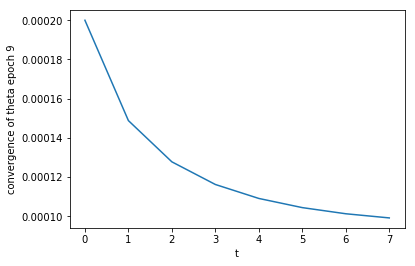

In [47]:
x = torch.randn(10, 4, requires_grad=False)
# Some polynomial
y_true = 2*x**2 - 5*x + 3

#Initial Random Guess
w1 = torch.randn(4, 1, requires_grad=True)
use_gpu = False
if use_gpu:
    w1, y, x = w1.cuda(), y.cuda(), x.cuda()

epochs = 10
alpha = 0.0001
beta1 = 0.9
beta2 = 0.9991
eps = 1e-8
optimizer = Adam(alpha, beta1, beta2, eps)
for epoch in range(epochs):
    y_p = x.mm(w1)
    loss = (y_p - y_true).pow(2).sum()
    loss.backward(retain_graph=True)
    gradient_t = w1.grad
    convergence = []
    w2 = optimizer.run(gradient_t, w1, convergence)
    plt.plot(convergence)
    plt.xlabel('t')
    plt.ylabel('convergence of theta epoch {}'.format(epoch))
    plt.show()

## Get latent features from Soccer Dataset and train a logistic regression classifier

In [ ]:
from test_soccer import get_features_soccer

In [ ]:
lr = 0.001
optim = 'adam'
model_epoch = 19
model_name = 'AutoEncoder_lr_{}_opt_{}_epoch_{}_dae'.format(lr, optim, model_epoch)

encoder = Encoder(batch_size=batch_size)
decoder = Decoder(batch_size=batch_size)

if use_gpu:
    encoder = encoder.cuda()
    decoder = decoder.cuda()
    
encoder.load_state_dict(load_model(model_name, key='state_dict_encoder'))
decoder.load_state_dict(load_model(model_name, key='state_dict_decoder'))

In [ ]:
n_in = 8192
model, train_loss = train_clf_soccer(encoder, batch_size=100, use_gpu=True)

In [ ]:
def test_img(path, encoder, model):
    img = Image.open(path)
    plt.imshow(img)
    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    img = transform(img)
    img = img.numpy()
    img = img[np.newaxis, ...]
    img = torch.Tensor(img)

    encoder.eval()
    model.eval()
    with torch.no_grad():
        latent_repr = encoder.forward(img)
        latent_repr = latent_repr.detach().cpu().numpy()
        output = model.predict(latent_repr)
        print('prediction: {}'.format(['not soccer', 'soccer'][output])

## Test classifier on new images

In [ ]:
test_path = 'Session6/SoccerData/test'
img1_path = test_path + '/test1.jpg'
test_img(img1_path, encoder, model)